In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score

In [2]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

In [3]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]
    
    return t

In [4]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [5]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = h_current[0]

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels
    
    # use the method in MH
    def get_cpt(self, x, h, y, id=[0, 1]):
        
        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        in_layers = self.fc_layers
        out_layers = self.fc_layers[1:] + [self.output_layer]
        
        prev_vals = [x] + h_current[:-1]
        curr_vals = h_current
        next_vals = h_current[1:] + [y]
        
        for i, (in_layer, out_layer, pv, cv, nv) in enumerate(
            zip(in_layers, out_layers, prev_vals, curr_vals, next_vals)):
            
            prob_parents = tf.math.sigmoid(in_layer(pv))
            
        
        
        

In [26]:
model = StochasticMLP(hidden_layer_sizes = [2], n_outputs=1)

In [27]:
network = [model.call(images) for images, labels in train_ds]

In [28]:
# Set weight
w_0 = np.array([[1, -1], [1, -1]], dtype = "float32")
b_0 = np.array([-0.5, 1], dtype = "float32")
l_0 = [w_0, b_0]

w_1 = np.array([[1], [1]], dtype = "float32")
b_1 = np.array([-1], dtype = "float32")
l_1 = [w_1, b_1]

model.fc_layers[0].set_weights(l_0)
model.output_layer.set_weights(l_1)

In [29]:
network = [model.call(images) for images, labels in train_ds]
network

[[<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
  array([[1, 1],
         [0, 0],
         [1, 1],
         [1, 0]], dtype=int32)>]]

In [30]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [31]:
burnin = 1000
step_sizes = []
for i in range(burnin):
    
    network_new = []
    kernels_new = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = tf.concat(net_current, axis = 1)
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2].new_step_size.numpy()
        step_sizes.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [2], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    #print(network[0])

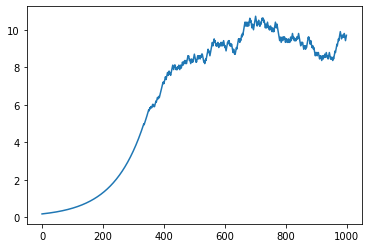

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [33]:
print(network[0])

[<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[-6.       ,  6.       ],
       [ 6.       ,  6.       ],
       [ 3.8416862,  6.       ],
       [ 3.4457765, -6.       ]], dtype=float32)>]


In [38]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new = []
        #kernels_new = []
        for net, hmc_kernel in zip(network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = tf.concat(net_current, axis = 1)
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [2], axis = 1)   
            network_new.append(net_new)

        network = network_new
        
        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/500: - 0.0551s/step - loss: 0.5838 - accuracy: 0.7500
Epoch 2/500: - 0.0750s/step - loss: 0.5820 - accuracy: 0.7500
Epoch 3/500: - 0.0631s/step - loss: 0.5820 - accuracy: 0.7500
Epoch 4/500: - 0.0576s/step - loss: 0.5819 - accuracy: 0.7500
Epoch 5/500: - 0.0535s/step - loss: 0.5819 - accuracy: 0.7500
Epoch 6/500: - 0.0517s/step - loss: 0.5818 - accuracy: 0.7500
Epoch 7/500: - 0.0494s/step - loss: 0.5818 - accuracy: 0.7500
Epoch 8/500: - 0.0476s/step - loss: 0.5817 - accuracy: 0.7500
Epoch 9/500: - 0.0463s/step - loss: 0.5817 - accuracy: 0.7500
Epoch 10/500: - 0.0452s/step - loss: 0.5816 - accuracy: 0.7500
Epoch 11/500: - 0.0452s/step - loss: 0.5816 - accuracy: 0.7500
Epoch 12/500: - 0.0454s/step - loss: 0.5815 - accuracy: 0.7500
Epoch 13/500: - 0.0446s/step - loss: 0.5815 - accuracy: 0.7500
Epoch 14/500: - 0.0439s/step - loss: 0.5815 - accuracy: 0.7500
Epoch 15/500: - 0.0434s/step - loss: 0.5814 - accuracy: 0.7500
Epoch 16/500: - 0.0439s/step - loss: 0.5814 - accuracy: 0.7500
E

Epoch 132/500: - 0.0423s/step - loss: 0.5785 - accuracy: 0.7500
Epoch 133/500: - 0.0423s/step - loss: 0.5800 - accuracy: 0.7500
Epoch 134/500: - 0.0423s/step - loss: 0.5799 - accuracy: 0.7500
Epoch 135/500: - 0.0422s/step - loss: 0.5784 - accuracy: 0.7500
Epoch 136/500: - 0.0422s/step - loss: 0.5784 - accuracy: 0.7500
Epoch 137/500: - 0.0422s/step - loss: 0.5783 - accuracy: 0.7500
Epoch 138/500: - 0.0423s/step - loss: 0.5783 - accuracy: 0.7500
Epoch 139/500: - 0.0422s/step - loss: 0.5782 - accuracy: 0.7500
Epoch 140/500: - 0.0422s/step - loss: 0.5782 - accuracy: 0.7500
Epoch 141/500: - 0.0421s/step - loss: 0.5783 - accuracy: 0.7500
Epoch 142/500: - 0.0421s/step - loss: 1.6290 - accuracy: 0.7500
Epoch 143/500: - 0.0420s/step - loss: 0.5784 - accuracy: 0.7500
Epoch 144/500: - 0.0420s/step - loss: 0.5783 - accuracy: 0.7500
Epoch 145/500: - 0.0420s/step - loss: 0.5783 - accuracy: 0.7500
Epoch 146/500: - 0.0419s/step - loss: 0.5782 - accuracy: 0.7500
Epoch 147/500: - 0.0418s/step - loss: 0.

Epoch 262/500: - 0.0402s/step - loss: 0.5731 - accuracy: 0.7500
Epoch 263/500: - 0.0402s/step - loss: 0.5731 - accuracy: 0.7500
Epoch 264/500: - 0.0401s/step - loss: 0.5730 - accuracy: 0.7500
Epoch 265/500: - 0.0401s/step - loss: 0.5730 - accuracy: 0.7500
Epoch 266/500: - 0.0401s/step - loss: 0.5729 - accuracy: 0.7500
Epoch 267/500: - 0.0401s/step - loss: 0.5729 - accuracy: 0.7500
Epoch 268/500: - 0.0401s/step - loss: 0.5729 - accuracy: 0.7500
Epoch 269/500: - 0.0401s/step - loss: 0.5728 - accuracy: 0.7500
Epoch 270/500: - 0.0401s/step - loss: 0.5728 - accuracy: 0.7500
Epoch 271/500: - 0.0401s/step - loss: 0.5727 - accuracy: 0.7500
Epoch 272/500: - 0.0401s/step - loss: 0.5727 - accuracy: 0.7500
Epoch 273/500: - 0.0401s/step - loss: 0.5727 - accuracy: 0.7500
Epoch 274/500: - 0.0401s/step - loss: 0.5726 - accuracy: 0.7500
Epoch 275/500: - 0.0401s/step - loss: 0.5726 - accuracy: 0.7500
Epoch 276/500: - 0.0400s/step - loss: 0.5726 - accuracy: 0.7500
Epoch 277/500: - 0.0400s/step - loss: 0.

Epoch 393/500: - 0.0392s/step - loss: 1.6605 - accuracy: 0.7500
Epoch 394/500: - 0.0392s/step - loss: 0.5716 - accuracy: 0.7500
Epoch 395/500: - 0.0392s/step - loss: 0.5698 - accuracy: 0.7500
Epoch 396/500: - 0.0392s/step - loss: 0.5698 - accuracy: 0.7500
Epoch 397/500: - 0.0392s/step - loss: 0.5697 - accuracy: 0.7500
Epoch 398/500: - 0.0392s/step - loss: 0.5697 - accuracy: 0.7500
Epoch 399/500: - 0.0392s/step - loss: 0.5687 - accuracy: 0.7500
Epoch 400/500: - 0.0392s/step - loss: 0.5686 - accuracy: 0.7500
Epoch 401/500: - 0.0392s/step - loss: 0.5686 - accuracy: 0.7500
Epoch 402/500: - 0.0392s/step - loss: 0.5686 - accuracy: 0.7500
Epoch 403/500: - 0.0392s/step - loss: 0.5685 - accuracy: 0.7500
Epoch 404/500: - 0.0392s/step - loss: 0.5685 - accuracy: 0.7500
Epoch 405/500: - 0.0392s/step - loss: 0.5685 - accuracy: 0.7500
Epoch 406/500: - 0.0392s/step - loss: 0.5684 - accuracy: 0.7500
Epoch 407/500: - 0.0392s/step - loss: 0.5684 - accuracy: 0.7500
Epoch 408/500: - 0.0392s/step - loss: 0.

In [ ]:
print(model.trainable_weights)

In [39]:
model2 = StochasticMLP(hidden_layer_sizes = [30], n_outputs=1)
network2 = [model2.call(images) for images, labels in train_ds]
kernels2 = [model2.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [40]:
print(network2)

[[<tf.Tensor: shape=(4, 30), dtype=int32, numpy=
array([[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)>]]


In [41]:
burnin = 1000
step_sizes2 = []
for i in range(burnin):
    
    #print(i)
    network_new2 = []
    kernels_new2 = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2][4].numpy()
        step_sizes2.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        #print(new_state)
        net_new = tf.split(new_state, [30], axis = 1)   
        network_new2.append(net_new)
        
        # build new kernel
        ker_new = model2.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new2.append(ker_new)
            
    network2 = network_new2
    kernels2 = kernels_new2
    

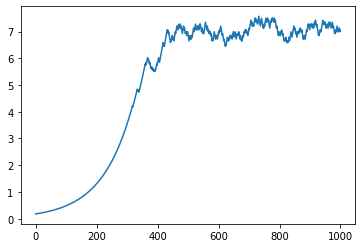

In [42]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes2)), step_sizes2)
plt.show()
pass

In [43]:
print(network2[0])

[<tf.Tensor: shape=(4, 30), dtype=float32, numpy=
array([[-6.        ,  6.        ,  6.        ,  3.452026  , -6.        ,
         4.947679  ,  2.320207  , -4.254197  , -6.        , -5.6089454 ,
         6.        ,  6.        ,  6.        ,  6.        ,  0.93498325,
         6.        ,  6.        , -2.1147652 , -6.        , -3.9191213 ,
         1.3871039 ,  0.60071373, -6.        ,  3.8207645 , -6.        ,
        -6.        , -6.        , -6.        ,  6.        , -0.70796275],
       [ 2.160128  , -6.        , -0.59218645, -6.        ,  6.        ,
        -6.        ,  6.        , -2.4475965 ,  6.        , -2.8963027 ,
        -4.4213486 ,  6.        ,  6.        ,  3.971283  , -6.        ,
         6.        ,  1.1097124 , -1.1559033 ,  6.        ,  4.27173   ,
         6.        , -6.        , -6.        ,  5.486821  ,  6.        ,
         6.        , -3.1119752 ,  6.        , -1.7854977 , -6.        ],
       [ 5.4353967 ,  6.        ,  6.        ,  5.6201305 ,  6.        ,

In [ ]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model2.update_weights(images, network2[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new2 = []
        for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [30], axis = 1)   
            network_new2.append(net_new)
            
        network2 = network_new2
        
        loss += -1 * tf.reduce_mean(model2.target_log_prob(images, network2[bs], labels))
    
    preds = [model2.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/500: - 0.0663s/step - loss: 20.5657 - accuracy: 0.5000
Epoch 2/500: - 0.0597s/step - loss: 20.8966 - accuracy: 0.5000
Epoch 3/500: - 0.0543s/step - loss: 21.7737 - accuracy: 0.5000
Epoch 4/500: - 0.0513s/step - loss: 20.8552 - accuracy: 0.5000
Epoch 5/500: - 0.0498s/step - loss: 20.9025 - accuracy: 0.5000
Epoch 6/500: - 0.0505s/step - loss: 21.3311 - accuracy: 0.5000
Epoch 7/500: - 0.0514s/step - loss: 21.0209 - accuracy: 0.5000
Epoch 8/500: - 0.0501s/step - loss: 20.7111 - accuracy: 0.5000
Epoch 9/500: - 0.0491s/step - loss: 20.7523 - accuracy: 0.5000
Epoch 10/500: - 0.0494s/step - loss: 20.4784 - accuracy: 0.5000
Epoch 11/500: - 0.0526s/step - loss: 20.1923 - accuracy: 0.5000
Epoch 12/500: - 0.0540s/step - loss: 20.5886 - accuracy: 0.5000
Epoch 13/500: - 0.0538s/step - loss: 20.3552 - accuracy: 0.5000
Epoch 14/500: - 0.0532s/step - loss: 20.3039 - accuracy: 0.5000
Epoch 15/500: - 0.0525s/step - loss: 19.9831 - accuracy: 0.5000
Epoch 16/500: - 0.0529s/step - loss: 19.5503 - ac

In [ ]:
0.0513*445

In [ ]:
tf.math.sigmoid(6.0)

In [ ]:
tf.math.sigmoid(-6.0)